
# Previsão de Sucesso de Startups

Este notebook documenta a análise exploratória, formulação de hipóteses e construção de um modelo de machine learning para prever o sucesso de startups a partir dos dados fornecidos no campeonato descrito no README.



## 1. Configuração

Importamos as bibliotecas permitidas pelo regulamento: NumPy, Pandas, Scikit-Learn e bibliotecas de visualização Matplotlib/Seaborn.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (10, 6)



## 2. Carregamento dos Dados

Lemos os arquivos `train.csv` e `test.csv`, verificando dimensões e estrutura básica.


In [2]:

data_dir = Path('.')
train_path = data_dir / 'train.csv'
test_path = data_dir / 'test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f'Tamanho do conjunto de treino: {train.shape}')
print(f'Tamanho do conjunto de teste: {test.shape}')
train.head()


Tamanho do conjunto de treino: (646, 33)
Tamanho do conjunto de teste: (277, 32)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


In [3]:

train.describe().T


,count,mean,std,min,25%,50%,75%,max
id,646.0,4.615774e+02,2.648595e+02,1.0,233.250,4.595000e+02,6.925000e+02,9.230000e+02
age_first_funding_year,611.0,2.341718e+00,2.468275e+00,0.0,0.680,1.650000e+00,3.600000e+00,2.190000e+01
age_last_funding_year,637.0,4.037724e+00,2.950923e+00,0.0,1.870,3.610000e+00,5.590000e+00,2.190000e+01
age_first_milestone_year,508.0,3.352657e+00,2.866952e+00,0.0,1.185,2.785000e+00,4.935000e+00,2.468000e+01
age_last_milestone_year,535.0,4.944729e+00,3.213319e+00,0.0,2.540,4.620000e+00,6.880000e+00,2.468000e+01
relationships,646.0,7.948916e+00,7.397602e+00,0.0,3.000,6.000000e+00,1.000000e+01,6.300000e+01
funding_rounds,646.0,2.351393e+00,1.357856e+00,1.0,1.000,2.000000e+00,3.000000e+00,8.000000e+00
funding_total_usd,646.0,2.949633e+07,2.261999e+08,11000.0,3000000.000,1.020000e+07,2.587500e+07,5.700000e+09
milestones,646.0,1.913313e+00,1.337095e+00,0.0,1.000,2.000000e+00,3.000000e+00,6.000000e+00
is_CA,646.0,5.464396e-01,4.982245e-01,0.0,0.000,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:

missing_train = train.isna().mean().sort_values(ascending=False)
missing_test = test.isna().mean().sort_values(ascending=False)

missing_summary = pd.DataFrame({
    'percentual_faltantes_treino': (missing_train * 100).round(2),
    'percentual_faltantes_teste': (missing_test * 100).round(2)
})
missing_summary.head(10)


,percentual_faltantes_treino,percentual_faltantes_teste
age_first_funding_year,5.42,3.97
age_first_milestone_year,21.36,21.66
age_last_funding_year,1.39,1.44
age_last_milestone_year,17.18,19.13
avg_participants,0.00,0.00
category_code,0.00,0.00
funding_rounds,0.00,0.00
funding_total_usd,0.00,0.00
has_VC,0.00,0.00
has_angel,0.00,0.00



## 3. Exploração e Visualização

Avaliamos a distribuição da variável alvo e investigamos relações entre variáveis contínuas e o sucesso das startups.


labels
0    228
1    418
Name: count, dtype: int64

Proporção de sucesso: 0.647


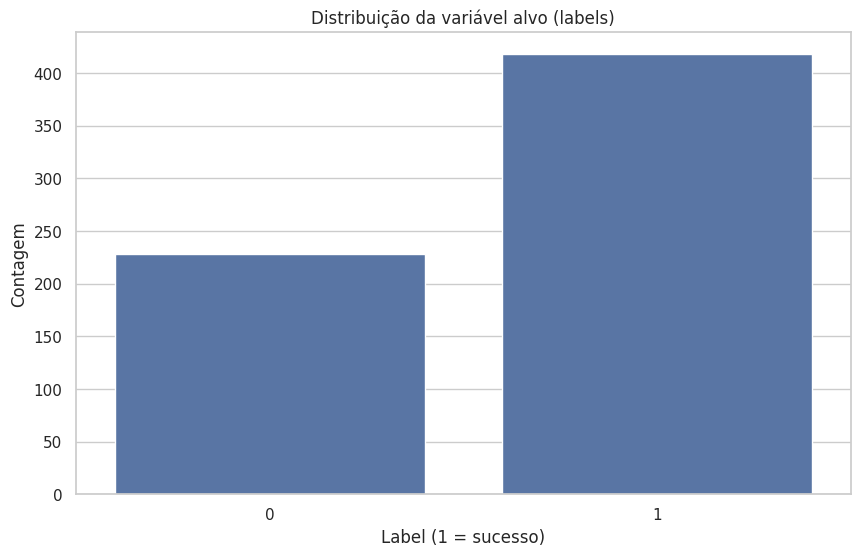

In [5]:
label_counts = train['labels'].value_counts().sort_index()
print(label_counts)
print()
proportion = label_counts[1] / label_counts.sum()
print(f'Proporção de sucesso: {proportion:.3f}')

sns.countplot(data=train, x='labels')
plt.title('Distribuição da variável alvo (labels)')
plt.xlabel('Label (1 = sucesso)')
plt.ylabel('Contagem')
plt.show()

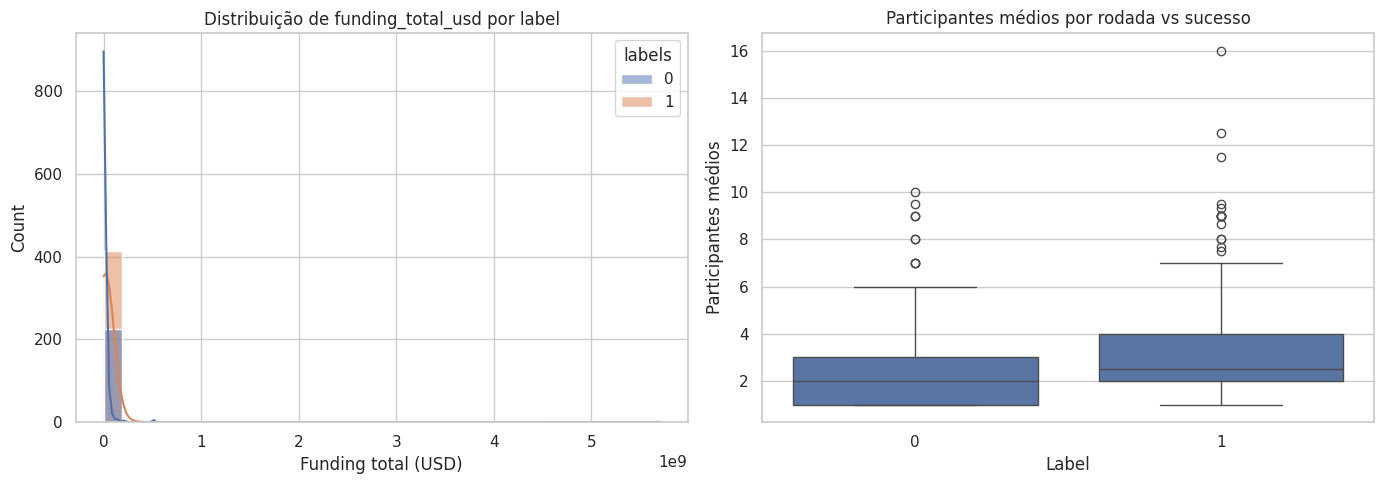

In [6]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=train, x='funding_total_usd', hue='labels', kde=True, ax=axes[0], bins=30)
axes[0].set_title('Distribuição de funding_total_usd por label')
axes[0].set_xlabel('Funding total (USD)')

sns.boxplot(data=train, x='labels', y='avg_participants', ax=axes[1])
axes[1].set_title('Participantes médios por rodada vs sucesso')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Participantes médios')

plt.tight_layout()
plt.show()


In [7]:

numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.drop(['labels', 'id'])
correlation = train[numeric_cols].corrwith(train['labels']).sort_values(key=lambda s: s.abs(), ascending=False)
correlation.head(10)


relationships              0.342841
milestones                 0.335149
age_last_milestone_year    0.257261
has_roundB                 0.214299
funding_rounds             0.212760
is_otherstate             -0.198638
avg_participants           0.194482
has_roundC                 0.172943
has_roundA                 0.171953
has_roundD                 0.166680
dtype: float64


### Formulação de Hipóteses

1. **Startups com histórico robusto de funding** (maior `funding_total_usd` e `funding_rounds`) têm maior probabilidade de sucesso, pois acesso a capital prolonga operações e acelera crescimento.
2. **Equipes com mais relacionamentos e marcos** (`relationships` e `milestones`) indicam redes sólidas e gestão estruturada, favorecendo a sobrevivência.
3. **Startups em setores digitais** (`is_software`, `is_web`, `is_mobile`) apresentam maior chance de sucesso, beneficiando-se de escalabilidade e investimento recorrente.



## 4. Preparação dos Dados

Selecionamos features relevantes, tratamos valores faltantes e aplicamos codificação/escala conforme necessário. A coluna `category_code` recebe one-hot encoding, enquanto colunas numéricas são imputadas pela mediana e padronizadas.


In [8]:

feature_cols = train.columns.drop(['labels'])
X = train[feature_cols]
y = train['labels']

categorical_cols = ['category_code']
numeric_cols = X.columns.drop(categorical_cols + ['id'])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])



## 5. Modelo Baseline

Treinamos um modelo de regressão logística com validação estratificada para obter uma linha de base de desempenho.


In [9]:

logistic_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=200, class_weight='balanced'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(logistic_pipeline, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'])

pd.DataFrame({metric: scores for metric, scores in cv_results.items() if metric.startswith('test_')}).mean()


test_accuracy     0.710507
test_precision    0.821067
test_recall       0.707975
test_f1           0.759314
dtype: float64


## 6. Ajuste de Hiperparâmetros

Realizamos uma busca em grade para refinar os parâmetros da regressão logística e comparamos com um `RandomForestClassifier` simples.


In [10]:

param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

grid_search = GridSearchCV(
    logistic_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)
print('Melhores parâmetros:', grid_search.best_params_)
print('Acurácia média (cv):', grid_search.best_score_)


Melhores parâmetros: {'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Acurácia média (cv): 0.7105068574836017


In [11]:

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_estimators=300, max_depth=None, min_samples_split=4))
])

rf_scores = cross_validate(rf_pipeline, X, y, cv=cv, scoring='accuracy')
print('Acurácia média RandomForest:', rf_scores['test_score'].mean())


Acurácia média RandomForest: 0.7909838998211092



## 7. Avaliação Final

Treinamos o melhor modelo nos dados de treino, avaliamo-lo em um conjunto de validação separado e inspecionamos métricas detalhadas.


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_logistic = grid_search.best_estimator_
best_logistic.fit(X_train, y_train)

y_pred = best_logistic.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
report = classification_report(y_valid, y_pred)
matrix = confusion_matrix(y_valid, y_pred)
print(f'Acurácia validação: {acc:.3f}')
print("\nRelatório de classificação:\n" + report)
print("\nMatriz de confusão:\n" + str(matrix))

Acurácia validação: 0.677

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.53      0.74      0.62        46
           1       0.82      0.64      0.72        84

    accuracy                           0.68       130
   macro avg       0.67      0.69      0.67       130
weighted avg       0.72      0.68      0.68       130


Matriz de confusão:
[[34 12]
 [30 54]]



## 8. Treinamento Final e Submissão

Reajustamos o melhor modelo em todo o conjunto de treino e geramos o arquivo `submission.csv` no formato solicitado.


In [13]:

final_model = grid_search.best_estimator_
final_model.fit(X, y)

test_predictions = final_model.predict(test)

submission = pd.DataFrame({
    'id': test['id'],
    'labels': test_predictions
})
submission_path = data_dir / 'submission.csv'
submission.to_csv(submission_path, index=False)
submission.head()


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1
